# In this notebook a time series of gas station prices is visualized with the help of folium

In [1]:
import refuel_tools as rt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import glob
from os import listdir
import folium
from folium.plugins import TimestampedGeoJson
import refuel_tools as rt

In [2]:
# Important variables:

# Center of HAMBURG - Used a the center to find the surounding gas stations
cof_hamburg = [53.572990, 10.028677]

# Number of gas station to plot
k = 50

# Number of days
n = 1

# Sample Rate for resampling the data
sample_rate = '1min'

# Fuel type e5, e10, or diesel as string
fuel_type = 'e5'


## Load the price data

In [3]:
# Load the raw csv price data to a pandas dataframe

df = rt.load_data_from_csv(timespan=n)

## Load gas station data


In [4]:
df_stations = pd.read_csv('./tankerkoenig-data/stations/2019/11/2019-11-08-stations.csv')

## Get the uuids for the gas stations in question

In [5]:
# Get the stations in Hamburg
df_uuid = rt.get_station_uuid_df(df_stations, cof_hamburg, k=k)

## Convert prices to continuous time series

In [6]:
df_ts = rt.make_timeseries(df, df_uuid, cutoff_days=7, sample_rate=sample_rate)

/Users/gabriel/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Scale the data and add the color 

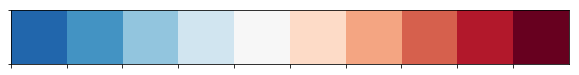

In [7]:
color_scale = ['#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
sns.palplot(sns.color_palette(color_scale))
bin_edges_e5 = np.linspace(0, 1, len(color_scale))

In [8]:
def color_coding(poll, bin_edges):    
    idx = np.digitize(poll, bin_edges, right=True)
    return color_scale[idx]

In [9]:
scaler = MinMaxScaler()
df_ts[fuel_type] = scaler.fit_transform(df_ts[[fuel_type]])
df_ts['color'] = df_ts.e5.apply(color_coding, bin_edges=bin_edges_e5)

## Convert dataframe to dict

In [11]:
def create_geojson_features(df):
    """
    This function takes in a pandas dataframe and creates a dict fitting for the folium plot.
    Input dataframe has to contain the following coloums: longitude, latitude, color
    
    INPUT:
        df = [dataframe] containing the data to plot. 
        
    OUTPUT:
        dict = [dict] in the shape folium wants it.
    """
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row.longitude,row.latitude]
            },
            'properties': {
                'time': row.date.__str__()[:-9],
                'style': {'color' : row.color},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row.color,
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 7
                }
            }
        }
        features.append(feature)
    return features

In [12]:
df_ts.reset_index(inplace=True)
features = rt.create_geojson_features(df_ts)

## Plot 

In [19]:
def make_map(features, location):
    print('> Making map...')
    price_map = folium.Map(location=location, 
                               control_scale=True, 
                               zoom_start=12,
                               #tiles = "CartoDB Positron"
                               tiles = 'cartodbdark_matter'
                              )

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='PT1M'
        , add_last_point=False
        , auto_play=False
        , loop=True
        , max_speed=16
        , loop_button=True
        , date_options='YYYY/MM/DD HH:MM'
        , time_slider_drag_update=True
    ).add_to(price_map)
    print('> Done.')
    return price_map

In [20]:
location = cof_hamburg
station_map = make_map(features, location)
station_map.save('./plots/time_series_geoplot_k_{}_days_{}_sample_rate_{}_new.html'.format(k,n,sample_rate))

> Making map...
> Done.
